# M124020052 林憲聰
# 2024/04/13 社群媒體分析 期中上機考
# 第一大題

In [261]:
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
import re #re: 正規表達式套件。
import jieba #jieba: 中文斷詞套件。
import jieba.analyse
import math #math: 數學運算工具。
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter, namedtuple #collections: 提供額外的數據類型。

import networkx as nx #networkx: 網絡圖建構、繪製工具。
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time
import datetime
from pprint import pprint
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from wordcloud import WordCloud


In [49]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

In [3]:
#匯入資料
df = pd.read_csv('./student_2_5_8.csv', encoding = 'UTF-8')
df.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent
0,1,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 09:10:04,退休就靠它了！存1000張中鋼又如何「昔領息300萬、今剩35萬」3檔老牌股 有吃有拿躺賺十年,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...
1,2,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 08:10:00,ETF月月配變有錢！「申購價10元很便宜？」破解背後2大投資迷思,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...
2,3,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 08:54:48,勞保年金才1.8萬！勞長喊所得替代率有68％「1動作還能衝上100％」,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...


In [27]:
clear_data = df.copy()

#去除本次不會用到的欄位
drop_cols = ['artUrl', 'dataSource', 'artUrl', 'artTitle']
clear_data.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_data.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#將日期格式重新整理
clear_data['artDate'] =  pd.to_datetime(clear_data['artDate']).dt.to_period('D')

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_data['sentence'] = clear_data['artContent'].str.replace(r'\n\n','。', regex=True)
clear_data['sentence'] = clear_data['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_data['sentence'] = clear_data['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_data.head()

,system_id,artDate,artContent,sentence
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）。根據...
1,2,2024-03-31,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...
2,3,2024-03-31,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...
3,4,2024-03-31,部分00940成分股開始出現利多出盡，必須留意高檔震盪風險，惟在資金輪動下，有利台股表現。（...,部分00940成分股開始出現利多出盡，必須留意高檔震盪風險，惟在資金輪動下，有利台股表現。（...
4,5,2024-03-31,規模直逼國安基金的00940將在4/1掛牌，上市後能否守穩10元發行價，是台股熱門話題。(圖...,規模直逼國安基金的00940將在4/1掛牌，上市後能否守穩10元發行價，是台股熱門話題。(圖...


In [28]:
clear_data['sentence'] = clear_data['sentence'].str.split("[,，。！!？?]{1,}")

Sent_Seg_data = clear_data.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
Sent_Seg_data['sentence'] = Sent_Seg_data['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
Sent_Seg_data = Sent_Seg_data[Sent_Seg_data["sentence"].str.len() > 1]

Sent_Seg_data

,system_id,artDate,artContent,sentence
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人提醒存錯股票
1,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,可能利息價差都雙輸
2,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,示意圖達志影像shutterstock
3,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,根據集保中心統計
4,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,中鋼總股東人數124萬人
...,...,...,...,...
29678,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,葉松炫認為
29679,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,隨AI新應用需求帶領半導體進入上升軌道
29680,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,對於半導體產業鏈的上游
29681,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,如設備儀器與材料需求將不斷提升


## 將之前過金融相關的斷詞字典匯入

In [152]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('./dict.txt')
#新增股票相關字典
jieba.load_userdict('./user_dict.txt')


Tokenisation_data = Sent_Seg_data.assign(word = Sent_Seg_data['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
Tokenisation_data = Tokenisation_data.loc[Tokenisation_data['word'].str.len() > 1]

Tokenisation_data


Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Team-8-Project/MIdtermExam/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uff1c8a6277c6e9b1fd63bcc1fa215111.cache
Loading model cost 0.272 seconds.
Prefix dict has been built successfully.


,system_id,artDate,artContent,word
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,提醒
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,存錯
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,股票
1,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,可能
...,...,...,...,...
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,相關
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,供應
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,製造商
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,獲利


## 將之前金融字典相關的情緒字
## 以及有錯誤的情緒字排除

In [173]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('./stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["張","現在","今年","完整","表示","影響","記者","問題","去年","產業",
                    "國際","億元","張","平均","以下","來源","報導","指出","知道","每度",
                    "20","未來","目前","超過"]
stopWords_manual2 = ["來源","市場","排行","大神","目前","是不是","也將","紅包","通知","讀版","圖片","以下","需要","連結","記者","署名","發文","發布","時間",
                    "心得","評論","正文","張數","原文","標題","網址","內文","口","張數","家數","年月日","單位","統計","證券","名稱","交易所","代號","謝謝",
                    "分類","標的","報導","格式", "股票名稱", "業者","依板", "版規", "刪除", "內容", "未依", "規處份", "輸入", "文處份", "處份", "股號",
                    "板規", "股名", "類免"]
stopwords.extend(stopwords_manual)
stopwords.extend(stopWords_manual2)



noStopword_data = Tokenisation_data[~Tokenisation_data['word'].isin(stopwords)]
noStopword_data

,system_id,artDate,artContent,word
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,提醒
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,存錯
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,股票
1,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,利息
...,...,...,...,...
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,相關
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,供應
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,製造商
29682,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,獲利


In [160]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [161]:
sentiment_liwc_data = pd.merge(noStopword_data[["system_id", "artDate", "artContent", "word"]], liwc_dict, how="left")
sentiment_liwc_data

,system_id,artDate,artContent,word,sentiments
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人,NaN
1,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,提醒,NaN
2,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,存錯,NaN
3,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,股票,NaN
4,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,利息,NaN
...,...,...,...,...,...
137688,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,相關,NaN
137689,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,供應,NaN
137690,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,製造商,NaN
137691,549,2024-03-15,全民瘋搶ETF，除了元大近日募集的「00940」外，國泰、群益、統一、復華等投信機構，都以高...,獲利,NaN


## 印出前15個正面情緒字

In [162]:
#依文章日期與情緒類別進行分組，並產生size()計算數量
sentiment_liwc_data_top15 = pd.DataFrame(
    sentiment_liwc_data.groupby(["word", "sentiments"]).size()
).reset_index()
sentiment_liwc_data_top15 = sentiment_liwc_data_top15.rename(columns={0: "size"})
sentiment_liwc_data_top15 = sentiment_liwc_data_top15.sort_values(["size"], ascending=False)
sentiment_liwc_data_ptop15 = sentiment_liwc_data_top15[sentiment_liwc_data_top15['sentiments'] == 'positive']
sentiment_liwc_data_ntop15 = sentiment_liwc_data_top15[sentiment_liwc_data_top15['sentiments'] == 'negative']
sentiment_liwc_data_ptop15.head(15)

,word,sentiments,size
183,受惠,positive,138
478,支撐,positive,87
205,吸引,positive,79
337,強勁,positive,74
891,重要,positive,72
745,穩健,positive,71
513,有利,positive,66
743,積極,positive,63
70,信心,positive,63
447,投入,positive,62


### 印出前15個負面情緒字

In [163]:
sentiment_liwc_data_ntop15.head(15)

,word,sentiments,size
939,風險,negative,456
790,自負,negative,148
340,強勢,negative,83
247,壓力,negative,57
912,降低,negative,34
471,擔心,negative,33
820,衝擊,negative,30
825,衰退,negative,28
474,擔憂,negative,23
948,驚人,negative,23


## 印出每天正面文章數量

In [164]:
sentiment_count = pd.DataFrame(
    sentiment_liwc_data.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count = sentiment_count[sentiment_count['sentiments'] == "positive"]
sentiment_count

,artDate,sentiments,size
4,2024-03-01,positive,95
10,2024-03-03,positive,19
16,2024-03-04,positive,134
22,2024-03-05,positive,48
28,2024-03-06,positive,87
34,2024-03-07,positive,105
40,2024-03-08,positive,125
46,2024-03-09,positive,44
52,2024-03-10,positive,25
57,2024-03-11,positive,74


# 第二大題

## 載入CKIP

In [39]:
ws = WS("/Users/aiden/Downloads/data") 
pos = POS("/Users/aiden/Downloads/data")
ner = NER("/Users/aiden/Downloads/data")

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2024-04-13 14:31:48.903082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This cl

In [40]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [45]:
# 自定義辭典
with open('./user_dict.txt') as f:
    lines = f.read().splitlines()

userdict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(userdict)
print(dictionary2)

[(2, {'中租': 500.0, '融券': 500.0, '增加': 500.0, '減少': 500.0, '券增': 500.0, '券減': 500.0, '資增': 500.0, '資減': 500.0, '台泥': 500.0, '亞泥': 500.0, '嘉泥': 500.0, '環泥': 500.0, '幸福': 500.0, '信大': 500.0, '東泥': 500.0, '味全': 500.0, '味王': 500.0, '大成': 500.0, '大飲': 500.0, '卜蜂': 500.0, '統一': 500.0, '泰山': 500.0, '福壽': 500.0, '台榮': 500.0, '佳格': 500.0, '聯華': 500.0, '天仁': 500.0, '黑松': 500.0, '興泰': 500.0, '宏亞': 500.0, '安心': 500.0, '德麥': 500.0, '乾杯': 500.0, '台塑': 500.0, '南亞': 500.0, '台聚': 500.0, '華夏': 500.0, '三芳': 500.0, '亞聚': 500.0, '台苯': 500.0, '國喬': 500.0, '聯成': 500.0, '達新': 500.0, '上曜': 500.0, '東陽': 500.0, '大洋': 500.0, '永裕': 500.0, '地球': 500.0, '恆大': 500.0, '台化': 500.0, '台翰': 500.0, '昭輝': 500.0, '八貫': 500.0, '新纖': 500.0, '南染': 500.0, '宏洲': 500.0, '東和': 500.0, '廣豐': 500.0, '嘉裕': 500.0, '東華': 500.0, '新紡': 500.0, '利華': 500.0, '福懋': 500.0, '中福': 500.0, '裕豐': 500.0, '中和': 500.0, '南紡': 500.0, '大東': 500.0, '名軒': 500.0, '立益': 500.0, '力麗': 500.0, '大宇': 500.0, '宏和': 500.0, '力鵬': 500.0, '佳和': 500.0, '年興': 500.0, '宏益': 

In [46]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [47]:
df.dropna(subset=['artContent'], inplace=True)
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 456.3151831626892


## 將CKIP結果存成檔案csv

In [48]:
# 將文章存成csv
pos_table.to_csv("ckipdata/pos_table_buffet.csv", index = False)
entity_table.to_csv("ckipdata/entity_table_buffet.csv", index = False)
sentence_table.to_csv("ckipdata/sentence_table_TSMC.csv", index = False)

## 過濾出名詞與動詞，並清除停用字

In [191]:
# 篩選名詞
noun = pos_table[pos_table.pos.isin(["Nb"])]

# 計算名詞次數
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count')

# 篩選動詞
verb = pos_table[pos_table.pos.isin(["VC"])]
verb = verb[verb['word'].map(len) > 1]  # 把長度為1的字去除掉

# 計算動詞次數
verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count')

# 合併名詞和動詞
combined_counts = pd.concat([noun_count, verb_count])

# 根據詞頻排序並取前100個
combined_counts_top100 = combined_counts.sort_values(['count'], ascending=False)
combined_counts_top100 = combined_counts_top100[~combined_counts_top100['word'].isin(stopwords)]
combined_counts_top100 = combined_counts.sort_values(['count'], ascending=False).head(100).reset_index()
combined_counts_top100 = combined_counts_top100.drop(["index"], axis = 1)
combined_counts_top100

,word,count
0,投資,902
1,張,794
2,台積電,486
3,表現,366
4,元大,323
...,...,...
95,神達,35
96,了結,34
97,召開,34
98,刷新,34


## 前100個字詞文字雲

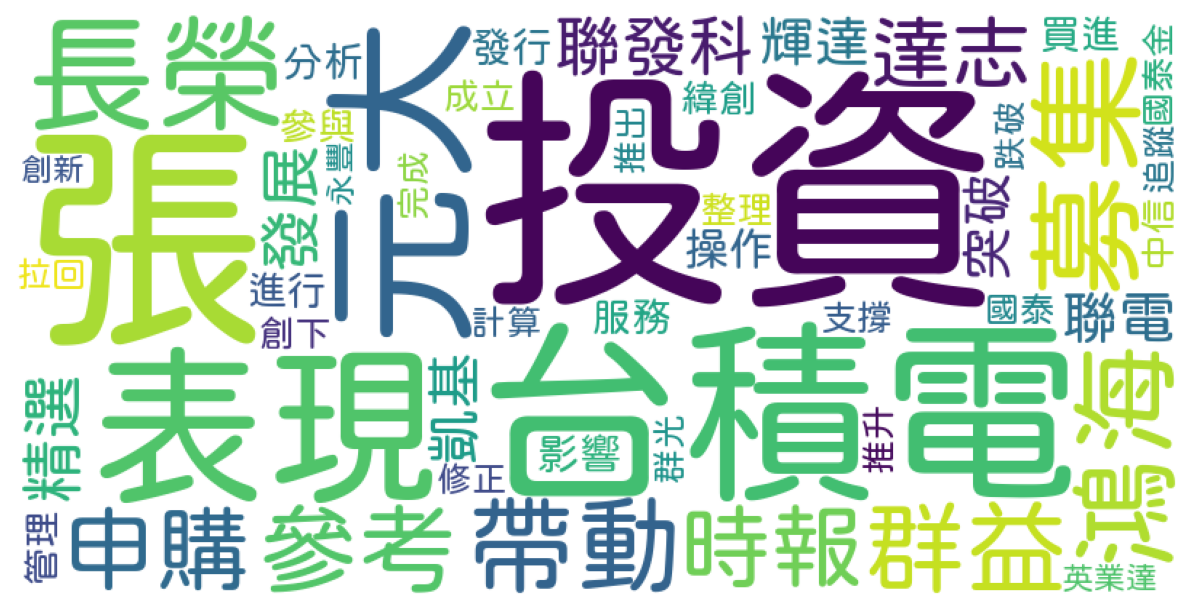

In [175]:
combined_counts_top100 = combined_counts_top100.set_index('word').to_dict()
combined_counts_top100 = combined_counts_top100['count']

# 繪製文字雲
wordcloud = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(combined_counts_top100)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# DTM計算

In [63]:
df.head()

,system_id,dataSource,artUrl,artDate,artTitle,artContent
0,1,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 09:10:04,退休就靠它了！存1000張中鋼又如何「昔領息300萬、今剩35萬」3檔老牌股 有吃有拿躺賺十年,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...
1,2,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 08:10:00,ETF月月配變有錢！「申購價10元很便宜？」破解背後2大投資迷思,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...
2,3,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 08:54:48,勞保年金才1.8萬！勞長喊所得替代率有68％「1動作還能衝上100％」,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...
3,4,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 06:10:00,你還在車上嗎？00940最終成分股曝光！鈊象超車聯電「4檔掉出前10大」,部分00940成分股開始出現利多出盡，必須留意高檔震盪風險，惟在資金輪動下，有利台股表現。（...
4,5,chinatimes,https://wantrich.chinatimes.com/news/202403319...,2024-03-31 04:10:00,台股資金流向丕變！00940將步00939破發後塵？謝金河：想割韭菜的小心了,規模直逼國安基金的00940將在4/1掛牌，上市後能否守穩10元發行價，是台股熱門話題。(圖...


In [64]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artUrl', 'artTitle', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

,system_id,artDate,artContent,sentence
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人提醒存錯股票可能利息價差都雙輸示意圖達志影像根據集保中心統計中鋼總股東人數萬人比台積電萬...
1,2,2024-03-31,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...,首檔結合價值投資元銅板發行價又月月配掀起空前搶購狂熱吸引小資族學生族申購示意圖達志影像元大臺...
2,3,2024-03-31,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...,除了雇主提撥薪資勞工個人也自提可望再多一倍勞退金示意圖達志影像各界質疑勞保平均請領數額僅有萬...


In [65]:
Midterexam_df = MetaData.copy()
Midterexam_df.head(3)

,system_id,artDate,artContent,sentence
0,1,2024-03-31,達人提醒存錯股票，可能利息、價差都雙輸。（示意圖/達志影像/shutterstock）\n\...,達人提醒存錯股票可能利息價差都雙輸示意圖達志影像根據集保中心統計中鋼總股東人數萬人比台積電萬...
1,2,2024-03-31,00940首檔結合價值投資、10元銅板發行價又月月配，掀起ETF空前搶購狂熱，吸引小資族、學...,首檔結合價值投資元銅板發行價又月月配掀起空前搶購狂熱吸引小資族學生族申購示意圖達志影像元大臺...
2,3,2024-03-31,除了雇主提撥薪資6％，勞工個人也自提6％，可望再多一倍勞退金。（示意圖/達志影像/shutt...,除了雇主提撥薪資勞工個人也自提可望再多一倍勞退金示意圖達志影像各界質疑勞保平均請領數額僅有萬...


In [69]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [70]:
# 保留需要的欄位
Midterexam_df = Midterexam_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
Midterexam_df['word'] = Midterexam_df.sentence.apply(getToken).map(' '.join)

Midterexam_df.head()

,system_id,sentence,word
0,1,達人提醒存錯股票可能利息價差都雙輸示意圖達志影像根據集保中心統計中鋼總股東人數萬人比台積電萬...,達人 提醒 存錯 股票 利息 價差 雙輸 示意圖 達志 影像 集保 中心 統計 中鋼 股東 ...
1,2,首檔結合價值投資元銅板發行價又月月配掀起空前搶購狂熱吸引小資族學生族申購示意圖達志影像元大臺...,首檔 結合 價值 投資 銅板 發行價 掀起 空前 搶購 狂熱 吸引 小資族 學生族 申購 示...
2,3,除了雇主提撥薪資勞工個人也自提可望再多一倍勞退金示意圖達志影像各界質疑勞保平均請領數額僅有萬...,雇主 提撥 薪資 勞工 自提 可望 一倍 勞退金 示意圖 達志 影像 各界 質疑 勞保 平均...
3,4,部分成分股開始出現利多出盡必須留意高檔震盪風險惟在資金輪動下有利台股表現示意圖達志影像元大台...,成分股 出現 利多 出盡 留意 高檔 震盪 風險 資金 輪動 有利 台股 表現 示意圖 達志...
4,5,規模直逼國安基金的將在掛牌上市後能否守穩元發行價是台股熱門話題圖中時報系資料照規模直逼國安基...,規模 直逼 國安 基金 將在 掛牌 上市 守穩 發行價 台股 熱門 話題 中時報系 資料 規...


In [76]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Midterexam_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一七遠,一三五元,一三出,一下,一下子,一五元,一五其,一些還,一人救,...,齊跌費,龍年,龍彩霖,龍德,龍海,龍頭,龍頭廠,龍騰,龐大,龐德
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 計算出該文件之DTM

In [77]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一七遠,一三五元,一三出,一下,一下子,一五元,一五其,一些還,一人救,...,齊跌費,龍年,龍彩霖,龍德,龍海,龍頭,龍頭廠,龍騰,龐大,龐德
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.064152,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.057163,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
545,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.22365,0.0,0.0,0.0,0.0
546,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
547,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


# 第三大題

## 匯入文件

In [140]:
#匯入資料
df_en = pd.read_csv('./emotion_samples.csv')
df_en.reset_index(inplace=True)
df_en.rename(columns={'index': 'index_column'}, inplace=True)
df_en.head(3)

,index_column,text,label
0,0,ive never been the mother of a teenage girl be...,sadness
1,1,i feel bad for pretty much everyone involved a...,sadness
2,2,i feel that someone is being rude or has wrong...,anger


In [141]:
##新增stop words
nltk.download('stopwords')
nltk.download('punkt')
print(nltk.data.path)

['/Users/aiden/nltk_data', '/opt/anaconda3/envs/python38/nltk_data', '/opt/anaconda3/envs/python38/share/nltk_data', '/opt/anaconda3/envs/python38/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package stopwords to /Users/aiden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aiden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [142]:
stopwords_path = "/Users/aiden/nltk_data/corpora/stopwords/english"
with open(stopwords_path, "r") as file:
    stopWords_en = file.read().splitlines()

In [143]:
# 設定斷詞 function
stemmer = PorterStemmer() #做Stemming還原詞幹

def getToken_en(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords_en and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords_en]
    return seg_list

## 透過Stemming stopword過濾字詞

In [251]:
data_en = df_en.copy()
data_en['word'] = data_en['text'].apply(getToken_en)
data_en = data_en.explode('word')
data_en.reset_index(inplace=True, drop=True) #重設index
data_en.head()

,index_column,text,label,word
0,0,ive never been the mother of a teenage girl be...,sadness,ive
1,0,ive never been the mother of a teenage girl be...,sadness,never
2,0,ive never been the mother of a teenage girl be...,sadness,mother
3,0,ive never been the mother of a teenage girl be...,sadness,teenag
4,0,ive never been the mother of a teenage girl be...,sadness,girl


In [252]:
# 各章節的總詞彙數
total_words = data_en.groupby(['index_column'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,index_column,total
0,0,16
1,1,24
2,2,7
3,3,18
4,4,7
...,...,...
4495,4495,6
4496,4496,2
4497,4497,7
4498,4498,10


In [253]:
# 各章節的總詞彙數
word_count = data_en.groupby(["index_column", "word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,index_column,word,count
0,0,crappi,1
1,0,episod,1
2,0,feel,1
3,0,girl,1
4,0,hell,1
...,...,...,...
40327,4499,feel,1
40328,4499,friend,1
40329,4499,met,1
40330,4499,new,1


In [254]:
tp_words = word_count.merge(total_words,on = 'index_column',how = 'left')

tp_words.head(10)

,index_column,word,count,total
0,0,crappi,1,16
1,0,episod,1,16
2,0,feel,1,16
3,0,girl,1,16
4,0,hell,1,16
5,0,humili,1,16
6,0,ive,1,16
7,0,left,1,16
8,0,littl,1,16
9,0,mother,1,16


In [255]:
# 計算tf
tp_words_tf_idf = tp_words.assign(tf = tp_words.iloc[:,2]/tp_words.iloc[:,3])
tp_words_tf_idf.head()

,index_column,word,count,total,tf
0,0,crappi,1,16,0.0625
1,0,episod,1,16,0.0625
2,0,feel,1,16,0.0625
3,0,girl,1,16,0.0625
4,0,hell,1,16,0.0625


In [256]:
# 計算每個詞彙出現在幾篇文章中
idf_df = tp_words.groupby(['word'],as_index=False).size()
tp_words_tf_idf = tp_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
tp_words_tf_idf.head()

,index_column,word,count,total,tf,size
0,0,crappi,1,16,0.0625,13
1,0,episod,1,16,0.0625,4
2,0,feel,1,16,0.0625,4411
3,0,girl,1,16,0.0625,38
4,0,hell,1,16,0.0625,11


In [257]:
# 計算idf
tp_words_tf_idf = tp_words_tf_idf.assign(idf = tp_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

tp_words_tf_idf = tp_words_tf_idf.drop(labels=['size'],axis=1)
tp_words_tf_idf.head()

,index_column,word,count,total,tf,idf
0,0,crappi,1,16,0.0625,2.539269
1,0,episod,1,16,0.0625,3.051153
2,0,feel,1,16,0.0625,0.008675
3,0,girl,1,16,0.0625,2.073429
4,0,hell,1,16,0.0625,2.611820


## 找出前200個tf-idf

In [258]:
# 計算 tf-idf
tp_words_tf_idf = tp_words_tf_idf.assign(tf_idf = tp_words_tf_idf.iloc[:,4] * tp_words_tf_idf.iloc[:,5])
tp_words_tf_idf = tp_words_tf_idf.head(200).sort_values(["tf_idf"], ascending=False).reset_index()
tp_words_tf_idf

,index,index_column,word,count,total,tf,idf,tf_idf
0,172,19,packet,2,6,0.333333,3.653213,1.217738
1,91,7,consider,1,3,0.333333,3.176091,1.058697
2,93,7,roommat,1,3,0.333333,2.875061,0.958354
3,127,13,disturb,1,3,0.333333,2.449093,0.816364
4,92,7,lack,1,3,0.333333,2.374459,0.791486
...,...,...,...,...,...,...,...,...
195,81,6,feel,1,13,0.076923,0.008675,0.000667
196,2,0,feel,1,16,0.062500,0.008675,0.000542
197,177,20,feel,1,16,0.062500,0.008675,0.000542
198,57,3,feel,1,18,0.055556,0.008675,0.000482


## 定義訓練模型

              precision    recall  f1-score   support

       anger       0.92      0.91      0.92      1026
         joy       0.89      0.92      0.90      1068
     sadness       0.88      0.87      0.88      1056

    accuracy                           0.90      3150
   macro avg       0.90      0.90      0.90      3150
weighted avg       0.90      0.90      0.90      3150



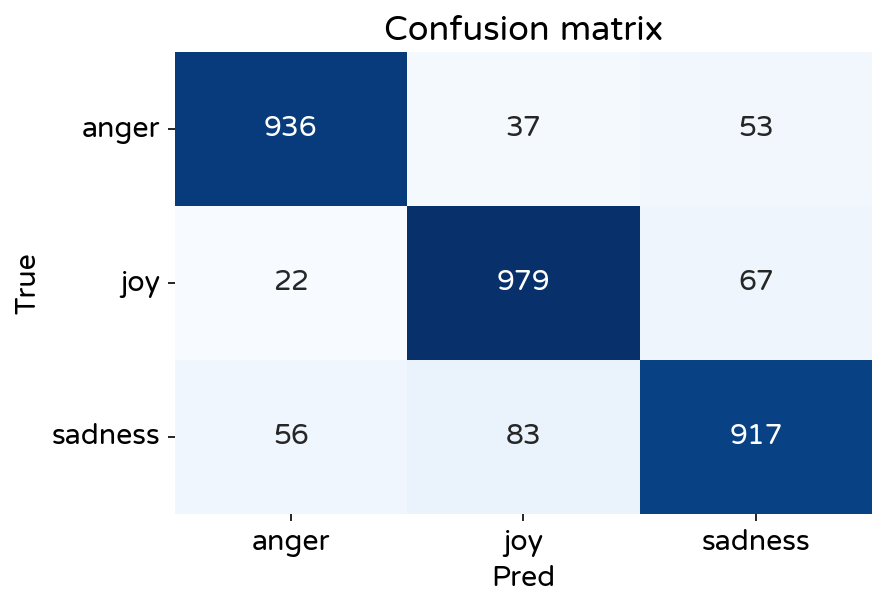

In [262]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    # one-hot encoding
    enc = OneHotEncoder(sparse_output=False)
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

## 比較模型不同的效果

now training: clf_logistic
              precision    recall  f1-score   support

       anger       0.92      0.91      0.92      1026
         joy       0.89      0.92      0.90      1068
     sadness       0.88      0.87      0.88      1056

    accuracy                           0.90      3150
   macro avg       0.90      0.90      0.90      3150
weighted avg       0.90      0.90      0.90      3150

now training: clf_dtree
              precision    recall  f1-score   support

       anger       0.86      0.93      0.89      1026
         joy       0.89      0.82      0.85      1068
     sadness       0.86      0.85      0.85      1056

    accuracy                           0.87      3150
   macro avg       0.87      0.87      0.87      3150
weighted avg       0.87      0.87      0.87      3150

now training: clf_svm


KeyboardInterrupt: 

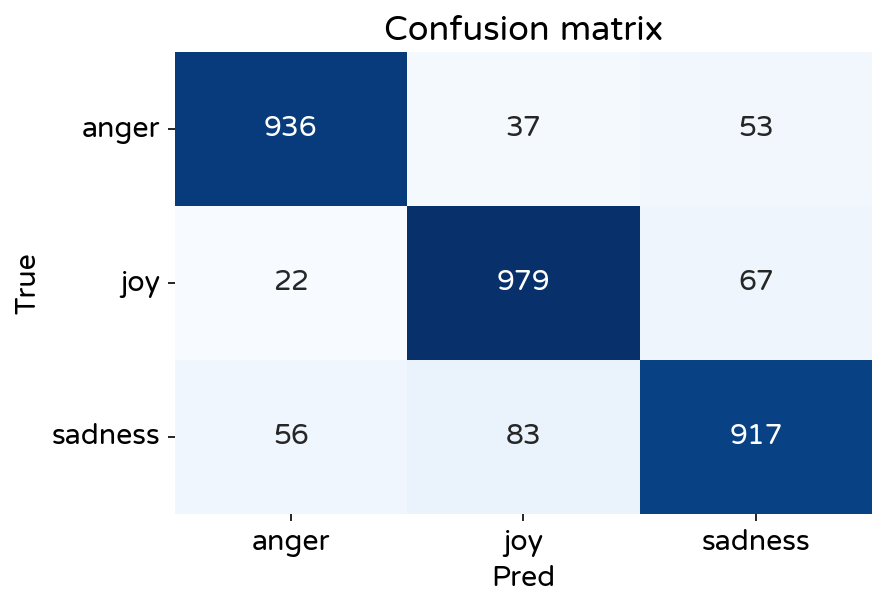

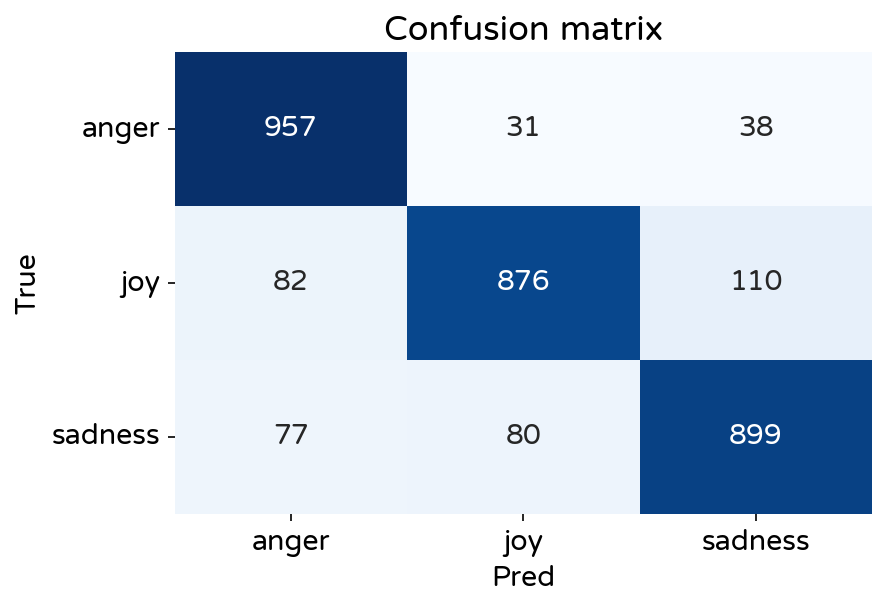

In [263]:
# 準備訓練資料
X = df_en["text"]
y = df_en["label"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

## 從F1-Score看來clf_logistic效果最好